In [1]:
import pandas as pd
import numpy as np
#from plotnine import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import BaggingClassifier 

from scipy.interpolate import interp1d
from scipy import interpolate
    
import statsmodels.api as sm
import itertools

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import xgboost as xgb
from catboost import CatBoostRegressor, Pool, cv


C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
train = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\training_input.csv', sep=';')
test = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\testing_input.csv', sep=';') 
output = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\challenge_output_data_training_file_volatility_prediction_in_financial_markets.csv', sep=';')

In [13]:
y_true = output["TARGET"]

In [14]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE_residus(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true)

In [15]:
train.head()

ID  date  product_id  volatility 09:30:00  volatility 09:35:00  \
0   1     1           1             0.662737             0.716896   
1   2     1           2             0.285394             0.379560   
2   3     1           3             1.151646             1.093562   
3   4     1           4             0.835260             0.329615   
4   5     1           5             0.274185             0.061076   

   volatility 09:40:00  volatility 09:45:00  volatility 09:50:00  \
0             0.698601             0.480172             0.623665   
1             0.094858             0.094794             0.055315   
2             1.833443             0.595823             0.310177   
3             0.340366             0.216692             0.350371   
4             0.010168             0.060890             0.000000   

   volatility 09:55:00  volatility 10:00:00       ...         return 13:10:00  \
0             0.201876             0.327206       ...                     1.0   
1             0.173994             0.102745       ...                     1.0   
2             0.792310             0.401979       ...                     1.0   
3             0.247594             0.341194       ...                    -1.0   
4             0.213162             0.162763       ...                    -1.0   

   return 13:15:00  return 13:20:00  return 13:25:00  return 13:30:00  \
0              1.0              1.0             -1.0              1.0   
1              1.0              1.0              1.0              1.0   
2              1.0             -1.0             -1.0              1.0   
3              1.0              1.0              0.0              1.0   
4              1.0              1.0              0.0              1.0   

   return 13:35:00  return 13:40:00  return 13:45:00  return 13:50:00  \
0             -1.0              0.0              1.0              1.0   
1             -1.0             -1.0              1.0             -1.0   
2              1.0             -1.0              1.0              1.0   
3             -1.0             -1.0             -1.0             -1.0   
4              0.0             -1.0             -1.0             -1.0   

   return 13:55:00  
0             -1.0  
1             -1.0  
2              1.0  
3              1.0  
4              0.0  

[5 rows x 111 columns]

In [16]:
print("train.shape", train.shape)
print("test.shape", test.shape)

train.shape (636313, 111)
test.shape (635397, 111)


In [17]:
train.columns

Index(['ID', 'date', 'product_id', 'volatility 09:30:00',
       'volatility 09:35:00', 'volatility 09:40:00', 'volatility 09:45:00',
       'volatility 09:50:00', 'volatility 09:55:00', 'volatility 10:00:00',
       ...
       'return 13:10:00', 'return 13:15:00', 'return 13:20:00',
       'return 13:25:00', 'return 13:30:00', 'return 13:35:00',
       'return 13:40:00', 'return 13:45:00', 'return 13:50:00',
       'return 13:55:00'],
      dtype='object', length=111)

let's drop the ID index and get ride of it

In [18]:
train.drop( columns="ID", inplace=True )
test.drop( columns="ID", inplace=True )

In [19]:
train.columns

Index(['date', 'product_id', 'volatility 09:30:00', 'volatility 09:35:00',
       'volatility 09:40:00', 'volatility 09:45:00', 'volatility 09:50:00',
       'volatility 09:55:00', 'volatility 10:00:00', 'volatility 10:05:00',
       ...
       'return 13:10:00', 'return 13:15:00', 'return 13:20:00',
       'return 13:25:00', 'return 13:30:00', 'return 13:35:00',
       'return 13:40:00', 'return 13:45:00', 'return 13:50:00',
       'return 13:55:00'],
      dtype='object', length=110)

We will consider return columns as category with -1, 0, 1 and -999 for NA

In [20]:
#train.loc[:,'return 09:30:00': 'return 13:50:00'].fillna(-999, inplace=True)
#test.loc[:,'return 09:30:00': 'return 13:50:00'].fillna(-999, inplace=True)
for i in test.loc[:, 'return 09:30:00': 'return 13:55:00'].columns:
    train[i].fillna(-999, inplace=True)
    test[i].fillna(-999, inplace=True)

cast return into integer

In [21]:

train.loc[:, 'return 09:30:00': 'return 13:55:00'] = train.loc[:, 'return 09:30:00': 'return 13:55:00'].astype('int32', copy=False)
train.iloc[:, 0:2] = train.iloc[:, 0:2].astype('int32', copy=False)

test.loc[:, 'return 09:30:00': 'return 13:55:00'] = test.loc[:, 'return 09:30:00': 'return 13:55:00'].astype('int32', copy=False)
test.iloc[:, 0:2] = test.iloc[:, 0:2].astype('int32', copy=False)

#print(train.dtypes)


Test data and train data set have strictily partionnioned set of dates
train: 1..2117
test: 2118, ... 4237

Say for a 75/25 split
trainning: 1..1563
valid: 1563..2117

so training/valid should be partionned on date

In [22]:
df= pd.concat([train, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]

X = training.iloc[: , :-1]
y = training.iloc[: ,-1]

X_valid = valid.iloc[: , :-1]
y_true = valid.iloc[: ,-1]

X_test = test 

In [103]:
#training, valid  = train_test_split(pd.concat([train, output["TARGET"]], axis=1), test_size=0.2, random_state=42)

#X, X_valid, y, y_true = train_test_split(train, output["TARGET"], train_size=0.75, random_state=42)

In [9]:
model = CatBoostRegressor(
    loss_function='MAPE',
    random_seed=42,
    logging_level='Silent', 
    learning_rate=0.001, 
    iterations=100, depth=6
)


### Velocity only, getting ride of NA

In [106]:
model.fit(
    #X.iloc[:,2:56], 
    np.nan_to_num(X.values[:,2:56]),
    y,
    #cat_features=categorical_features_indices,
    #eval_set=(X_valid, y_true),
    verbose=True
#     logging_level='Verbose',  # you can uncomment this for text output
    #plot=True
)

0:	learn: 0.9282261	total: 119ms	remaining: 11.8s
1:	learn: 0.8587321	total: 219ms	remaining: 10.7s
2:	learn: 0.7923802	total: 310ms	remaining: 10s
3:	learn: 0.7344589	total: 403ms	remaining: 9.67s
4:	learn: 0.6786901	total: 493ms	remaining: 9.36s
5:	learn: 0.6326897	total: 583ms	remaining: 9.13s
6:	learn: 0.6000495	total: 665ms	remaining: 8.83s
7:	learn: 0.5676177	total: 771ms	remaining: 8.86s
8:	learn: 0.5402773	total: 875ms	remaining: 8.85s
9:	learn: 0.5164113	total: 976ms	remaining: 8.78s
10:	learn: 0.4950180	total: 1.1s	remaining: 8.87s
11:	learn: 0.4762493	total: 1.21s	remaining: 8.87s
12:	learn: 0.4571502	total: 1.31s	remaining: 8.8s
13:	learn: 0.4423733	total: 1.42s	remaining: 8.74s
14:	learn: 0.4294847	total: 1.53s	remaining: 8.67s
15:	learn: 0.4227854	total: 1.64s	remaining: 8.59s
16:	learn: 0.4122177	total: 1.75s	remaining: 8.54s
17:	learn: 0.4026908	total: 1.86s	remaining: 8.46s
18:	learn: 0.3958483	total: 1.96s	remaining: 8.35s
19:	learn: 0.3877730	total: 2.07s	remaining: 

In [107]:
y_pred = model.predict(np.nan_to_num(X_valid.values[:,2:56])) #X_valid.iloc[:,2:56]
m= MAPE(y_true, y_pred)
yt = model.predict(np.nan_to_num(X.values[:,2:56])) #(X.iloc[:,2:56])
t= MAPE(y, yt) 

print("mape training:    ", t)
print("mape valid:    ", m)


mape training:     28.018670730908223
mape valid:     25.848325016351204


### Volatility only, with NA

XGboost reference:
- mape valid:    150 24.788070107874834
- mape training: 150 24.919307578048606
- delta -0.1312374701737724

In [39]:
model = CatBoostRegressor(
    loss_function='MAPE',
    random_seed=42,
    logging_level='Silent', 
    learning_rate=0.001, 
    iterations=1000, depth=3
)

In [40]:
model.fit(
    X.iloc[:,2:56], 
    #np.nan_to_num(X.values[:,2:56]),
    y,
    #cat_features=categorical_features_indices,
    eval_set=(X_valid.iloc[:,2:56], y_true),
    #verbose=True,
#     logging_level='Verbose',  
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [41]:
y_pred = model.predict(X_valid.iloc[:,2:56])
m= MAPE(y_true, y_pred)
yt = model.predict(X.iloc[:,2:56])
t= MAPE(y, yt) 

print("mape training:    ", t)
print("mape valid:    ", m)

mape training:     26.907363729560874
mape valid:     25.203357035470425


trying cv

In [10]:

xx = train.iloc[:,2:56]
yy = output["TARGET"]

pool = Pool(xx, yy)
params = {'iterations': 500, 'depth': 6, 'loss_function': 'MAPE', 'logging_level': 'Silent', 'learning_rate' :0.001, 
         'random_seed' : 42} #'shuffle' : True
scores = cv( pool=pool, params=params,  plot=True, shuffle= False )
#print(scores)
          

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [64]:
from time import sleep


xx = train.iloc[:,2:56]
yy = output["TARGET"]
for i in range(3, 8):
    pool = Pool(xx, yy)
    params = {'iterations': 300, 'depth': i, 'loss_function': 'MAPE', 'logging_level': 'Silent', 'learning_rate' :0.001, 
             'random_seed' : 42} #'shuffle' : True
    scores = cv( pool=pool, params=params,  plot=True, shuffle= False )  
    sleep(0.5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'catboost_info\\catboost_training.json'

In [61]:
for i in range(3, 8):
    model = CatBoostRegressor(
        loss_function='MAPE',
        random_seed=42,
        logging_level='Silent', 
        learning_rate=0.001, 
        iterations=500, depth=i
    )

    model.fit(
        X.iloc[:,1:56], 
        #np.nan_to_num(X.values[:,2:56]),
        y,
        cat_features=[0],
        eval_set=(X_valid.iloc[:,1:56], y_true),
        #verbose=True,
    #     logging_level='Verbose',  # you can uncomment this for text output
        plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

Submitting for references

In [42]:
df= pd.concat([train, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]

X = training.iloc[: , :-1]
y = training.iloc[: ,-1]

X_valid = valid.iloc[: , :-1]
y_true = valid.iloc[: ,-1]

X_test = test 

In [44]:
model = CatBoostRegressor(
    loss_function='MAPE',
    random_seed=42,
    logging_level='Silent', 
    learning_rate=0.001, 
    iterations=241, depth=3
)

model.fit(
    X.iloc[:,2:56], 
    #np.nan_to_num(X.values[:,2:56]),
    y,
    #cat_features=categorical_features_indices,

    #verbose=True,
#     logging_level='Verbose',  
    plot=True
)


logy_pred  = model.predict(X_test.iloc[:,2:56])
y_pred = np.exp(logy_pred)

logyt = model.predict(X.iloc[:,2:56])
yt = np.exp(logyt)
t= MAPE(y, yt) 
print("MAPE on training data set:", t)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE on training data set: 805.5953484096506


### with  product id as category
- no apparent progress

In [29]:
model = CatBoostRegressor(
    loss_function='MAPE',
    random_seed=42,
    logging_level='Silent', 
    learning_rate=0.001, 
    iterations=500, depth=6
)

In [30]:
model.fit(
    X.iloc[:,1:56], 
    #np.nan_to_num(X.values[:,2:56]),
    y,
    cat_features=[0],
    eval_set=(X_valid.iloc[:,1:56], y_true),
    #verbose=True,
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [112]:
y_pred = model.predict(X_valid.iloc[:,:56])
m= MAPE(y_true, y_pred)
yt = model.predict(X.iloc[:,:56])
t= MAPE(y, yt) 

print("mape training:    ", t)
print("mape valid:    ", m)

mape training:     31.229601012414644
mape valid:     26.173084156078737


In [31]:
xx = train.iloc[:,2:56]
yy = output["TARGET"]

pool = Pool(xx, yy)
params = {'iterations': 500, 'depth': 6, 'loss_function': 'MAPE', 'logging_level': 'Silent', 'learning_rate' :0.001, 
         'random_seed' : 42} #'shuffle' : True
scores = cv( pool=pool, params=params,  plot=True, shuffle= False )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Looking at learning rate

In [118]:
Lm = []
Lt= []
Ld = []
#0.0002
r = range(3, 12)
for i in r:
    model = CatBoostRegressor(
    loss_function='MAPE',
    random_seed=42,
    logging_level='Silent', 
    learning_rate=i/10000, 
    iterations=201, 
    depth=6
    )
    model.fit(
    X.iloc[:,:56], 
    #np.nan_to_num(X.values[:,2:56]),
    y,
    cat_features=[0, 1],
    eval_set=(X_valid.iloc[:,:56], y_true),
    #verbose=True,
#     logging_level='Verbose',  # you can uncomment this for text output
    #plot=True
    )
    
    y_pred = model.predict(X_valid.iloc[:,:56])
    m= MAPE(y_true, y_pred)
    yt = model.predict(X.iloc[:,:56])
    t= MAPE(y, yt) 
              
    print("mape valid:    "+ str(i/10000), m)
    print("mape training: "+ str(i/10000), t)
    print("delta", m-t)
    print("--------------")              
                     
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    0.0003 28.94800682819656
mape training: 0.0003 27.206090863973092
delta 1.7419159642234696
--------------
mape valid:    0.0004 27.651662848410556
mape training: 0.0004 25.621303899315535
delta 2.030358949095021
--------------
mape valid:    0.0005 27.35027609873643
mape training: 0.0005 27.839730385062794
delta -0.4894542863263638
--------------
mape valid:    0.0006 27.066157779322342
mape training: 0.0006 25.693932981659746
delta 1.3722247976625965
--------------
mape valid:    0.0007 26.4883190934005
mape training: 0.0007 23.959594012936456
delta 2.528725080464042
--------------
mape valid:    0.0008 26.489791949300024
mape training: 0.0008 29.188210018044252
delta -2.6984180687442283
--------------
mape valid:    0.0009 26.225273321488192
mape training: 0.0009 24.40264243848378
delta 1.8226308830044111
--------------
mape valid:    0.001 26.194438386072193
mape training: 0.001 31.187330031091285
delta -4.9928916450190926
--------------
mape valid:    0.0011 27.01600

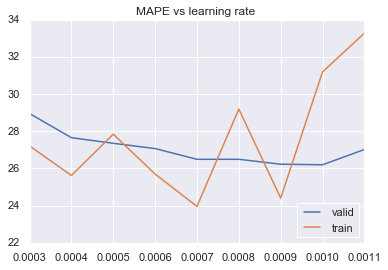

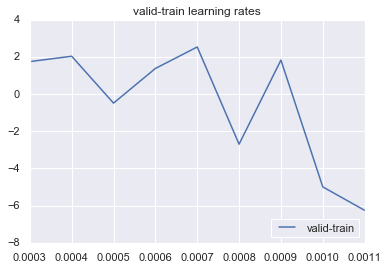

In [119]:

l= pd.Series(range(3, 12))/10000

plt.plot(l, Lm, label = "valid")
plt.plot(l, Lt, label = "train")

plt.legend(loc='lower right')
plt.title('MAPE vs learning rate ')
plt.show()

plt.plot(l, Ld, label = "valid-train")

plt.legend(loc='lower right')
plt.title('valid-train learning rates')
plt.show()

## Transformation on y: fitting on log(y)
with volatility only

ref xgboost
- mape valid:    150 24.788070107874834
- mape training: 150 24.919307578048606
- delta -0.1312374701737724

catboost MAPE ref: ~25.5

In [57]:
df= pd.concat([train, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]

X = training.iloc[: , :-1]
y = training.iloc[: ,-1]

X_valid = valid.iloc[: , :-1]
y_true = valid.iloc[: ,-1]

X_test = test 

logy = np.log(y)

In [58]:
model = CatBoostRegressor(
    #loss_function='RMSE',
    random_seed=42,
    logging_level='Silent', 
    learning_rate=0.001, 
    iterations=150, depth=3
)


In [59]:
model.fit(
    X.iloc[:,2:56], 
    #np.nan_to_num(X.values[:,2:56]),
    logy,
    #cat_features=[0],
    #eval_set=(X_valid.iloc[:,2:56], np.log(y_true)),
    #verbose=True,
#     logging_level='Verbose',  # you can uncomment this for text output
    #plot=True
)



logy_pred = model.predict(X_valid.iloc[:,2:56])
y_pred = np.exp(logy_pred )
m= MAPE(y_true, y_pred)
logyt = model.predict(X.iloc[:,2:56])
yt = np.exp(logyt)
t= MAPE(y, yt)   

print("mape valid:    ", m)
print("mape training: ", t)
print("delta", m-t)

mape valid:     493.831707455014
mape training:  507.2530562299019
delta -13.421348774887917


In [36]:
xx = train.iloc[:,2:56]
yy = output["TARGET"]

pool = Pool(xx, yy)
params = {'iterations': 500, 'depth': 6, 'loss_function': 'MAPE', 'logging_level': 'Silent', 'learning_rate' :0.001, 
         'random_seed' : 42} #'shuffle' : True
scores = cv( pool=pool, params=params,  plot=True, shuffle= False )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

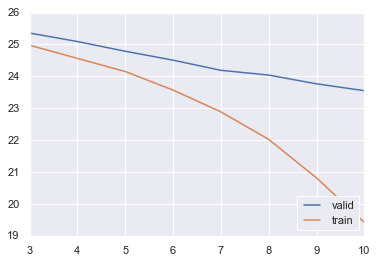

In [118]:
plt.plot(r, Lm, label = "valid")
plt.plot(r, Lt, label = "train")

plt.legend(loc='lower right')


In [124]:
Lm = []
Lt= []
Ld = []

r = range(50, 170, 10)
for i in r:
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=0.75,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
                     
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    50 26.307876123923684
mape training: 50 25.94023615433666
delta 0.3676399695870245
--------------
mape valid:    60 25.815165863937512
mape training: 60 25.462249794825876
delta 0.352916069111636
--------------
mape valid:    70 25.59749548119921
mape training: 70 25.245668285667623
delta 0.3518271955315875
--------------
mape valid:    80 25.483820017084923
mape training: 80 25.1233107781263
delta 0.36050923895862397
--------------
mape valid:    90 25.42075326659398
mape training: 90 25.044742592515313
delta 0.3760106740786675
--------------
mape valid:    100 25.358735445777164
mape training: 100 24.977022848210964
delta 0.38171259756619946
--------------
mape valid:    110 25.307713870326292
mape training: 110 24.925839465230222
delta 0.3818744050960703
--------------
mape valid:    120 25.260048274674663
mape training: 120 24.877505816618807
delta 0.3825424580558554
--------------
mape valid:    130 25.218647458571514
mape training: 130 24.833119022166382
delta 0.38

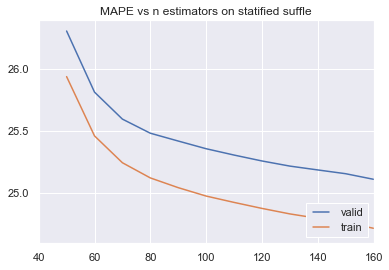

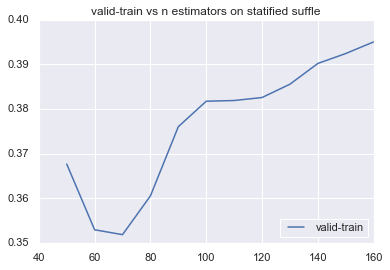

In [125]:
plt.plot(r, Lm, label = "valid")
plt.plot(r, Lt, label = "train")

plt.legend(loc='lower right')
plt.title('MAPE vs n estimators on statified suffle')
plt.show()

plt.plot(r, Ld, label = "valid-train")

plt.legend(loc='lower right')
plt.title('valid-train vs n estimators on statified suffle')
plt.show()

In [126]:
i=120
xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=0.75,  
                   random_state=42, n_jobs=-1)
xbr.fit(X, logy)

logy_pred = xbr.predict(X_valid)
y_pred = np.exp(logy_pred )
m= MAPE(y_true, y_pred)
logyt = xbr.predict(X)
yt = np.exp(logyt)
t= MAPE(y, yt)                
print("mape valid:    "+ str(i), m)
print("mape training: "+ str(i), t)
print("delta", m-t)
print("--------------")              

mape valid:    120 25.260048274674663
mape training: 120 24.877505816618807
delta 0.3825424580558554
--------------


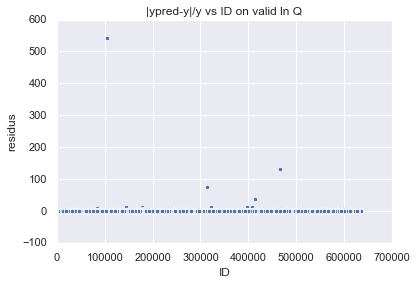

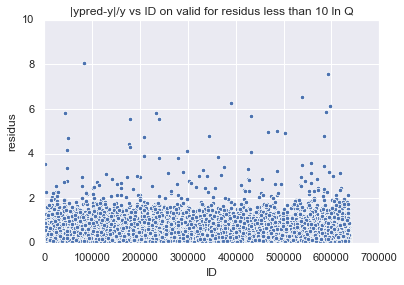

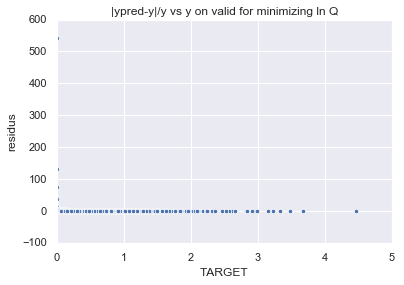

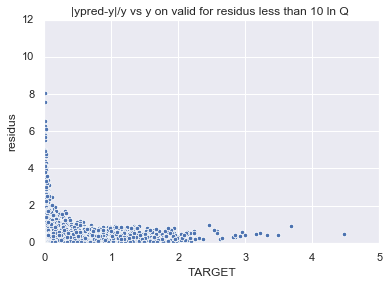

In [134]:
df= valid.copy()
df["ypred"]= y_pred
df["residus"]= MAPE_residus(df["TARGET"], df["ypred"])

ax = sns.scatterplot(x=df["ID"], y=df["residus"], data=df)
ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("|ypred-y|/y vs ID on valid ln Q")
plt.show()

resless10 = df[df.residus<10]
ax = sns.scatterplot(x=resless10["ID"], y=resless10["residus"], data=resless10)
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.title("|ypred-y|/y vs ID on valid for residus less than 10 ln Q")
plt.show()

ax = sns.scatterplot(x=df["TARGET"], y=df["residus"], data=df)
ax.set_xlim(0,)
#ax.set_ylim(0,)
plt.title("|ypred-y|/y vs y on valid for minimizing ln Q")
plt.show()

ax = sns.scatterplot(x=resless10["TARGET"], y=resless10["residus"], data=resless10)
ax.set_xlim(0,)
ax.set_ylim(0,12)
plt.title("|ypred-y|/y vs y on valid for residus less than 10 ln Q ")
plt.show()


In [154]:
MAPE(y_true, y_pred)

25.260048274674663

In [136]:
np.median(np.abs((y_true - y_pred) / y_true)) * 100

19.177345193727586

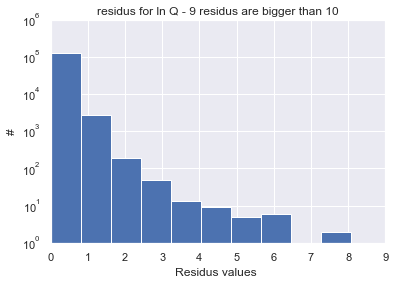

In [153]:
plt.hist(df.residus[df.residus<10] )
plt.title("residus for ln Q - 9 residus are bigger than 10")
plt.xlabel("Residus values ")
plt.ylabel("#")
plt.yscale('log', nonposy='clip')

In [151]:
df.residus[df.residus>10].shape

(9,)

In [12]:

y = output["TARGET"]
logy = np.log(y)
X = train.loc[:, 'date':]
X_Test = test.loc[:, 'date':]

In [15]:

xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=120,  subsample=0.75,  
                       random_state=42, n_jobs=-1)
xbr.fit(X, logy)
logy_pred  = xbr.predict(X_Test)
y_pred = np.exp(logy_pred)

logyt = xbr.predict(X)
yt = np.exp(logyt)
t= MAPE(y, yt) 
print("MAPE on training data set:", t)

MAPE on training data set: [0.17105149 0.07368656 0.278378   ... 0.16372475 0.08435931 0.10783206]


In [17]:
print("MAPE on training data set:", t)


MAPE on training data set: 24.92010370083335


In [18]:
#score 35.59367158016!!
d = {'TARGET':y_pred}
result = pd.DataFrame(data=d)
result.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\processed\\xgb_raw_Q_3_120.csv', 
              sep = ";",index_label="ID") 

let's try with the hyper parameters which gave score on volatitity 

In [10]:

xbr= xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=900,  subsample=0.7,  
                       random_state=42, n_jobs=-1)
xbr.fit(train, output["TARGET"])

y_pred = xbr.predict(test)

In [12]:
#Score:  44.715949563018 / mape on valid 23.567789388911986
d = {'TARGET':y_pred}
result = pd.DataFrame(data=d)
result.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\processed\\xgb_raw_vol_ret_10_900.csv', 
              sep = ";",index_label="ID") 

### Importance for volatility 

In [31]:
X.columns

Index(['volatility 09:30:00', 'volatility 09:35:00', 'volatility 09:40:00',
       'volatility 09:45:00', 'volatility 09:50:00', 'volatility 09:55:00',
       'volatility 10:00:00', 'volatility 10:05:00', 'volatility 10:10:00',
       'volatility 10:15:00', 'volatility 10:20:00', 'volatility 10:25:00',
       'volatility 10:30:00', 'volatility 10:35:00', 'volatility 10:40:00',
       'volatility 10:45:00', 'volatility 10:50:00', 'volatility 10:55:00',
       'volatility 11:00:00', 'volatility 11:05:00', 'volatility 11:10:00',
       'volatility 11:15:00', 'volatility 11:20:00', 'volatility 11:25:00',
       'volatility 11:30:00', 'volatility 11:35:00', 'volatility 11:40:00',
       'volatility 11:45:00', 'volatility 11:50:00', 'volatility 11:55:00',
       'volatility 12:00:00', 'volatility 12:05:00', 'volatility 12:10:00',
       'volatility 12:15:00', 'volatility 12:20:00', 'volatility 12:25:00',
       'volatility 12:30:00', 'volatility 12:35:00', 'volatility 12:40:00',
       'vola

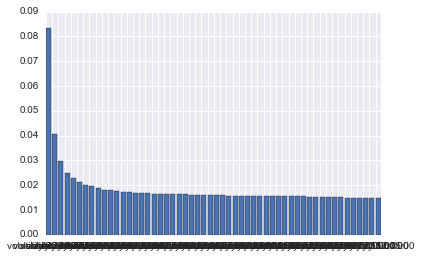

importance
volatility 09:30:00    0.083501
volatility 09:35:00    0.040811
volatility 09:40:00    0.029950
volatility 09:45:00    0.024844
volatility 09:50:00    0.022953
volatility 09:55:00    0.021168
volatility 10:00:00    0.019981
volatility 10:05:00    0.019693
volatility 10:10:00    0.018920
volatility 10:15:00    0.018259
volatility 10:20:00    0.018094
volatility 13:55:00    0.017855
volatility 10:25:00    0.017433
volatility 10:30:00    0.017427
volatility 10:40:00    0.016987
volatility 10:35:00    0.016876
volatility 10:45:00    0.016747
volatility 11:05:00    0.016612
volatility 12:10:00    0.016382
volatility 10:50:00    0.016372
volatility 11:00:00    0.016363
volatility 10:55:00    0.016347
volatility 13:50:00    0.016299
volatility 11:30:00    0.016011
volatility 13:45:00    0.015965
volatility 11:10:00    0.015961
volatility 11:35:00    0.015938
volatility 13:10:00    0.015869
volatility 13:40:00    0.015860
volatility 11:25:00    0.015759
volatility 12:40:00    0.015737
volatility 12:30:00    0.015730
volatility 11:40:00    0.015727
volatility 11:20:00    0.015725
volatility 11:45:00    0.015722
volatility 11:15:00    0.015711
volatility 11:50:00    0.015633
volatility 11:55:00    0.015631
volatility 13:20:00    0.015602
volatility 12:45:00    0.015594
volatility 13:25:00    0.015590
volatility 13:35:00    0.015576
volatility 12:00:00    0.015252
volatility 13:15:00    0.015224
volatility 12:35:00    0.015192
volatility 12:20:00    0.015181
volatility 12:25:00    0.015142
volatility 13:30:00    0.015075
volatility 12:50:00    0.015036
volatility 12:55:00    0.015023
volatility 12:15:00    0.015014
volatility 13:05:00    0.014913
volatility 13:00:00    0.014872
volatility 12:05:00    0.014862

In [30]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

(509050, 54)